# No Free Lunch Theorem
* ConvNet makes an assumption on the locality & the stationarity of images: http://cs231n.github.io/convolutional-networks/#fc
* Fully-Connected Networks don't
## In this notebook we will look at the MNIST dataset:
* Compare ConvNet & Fully-Connected NNs
* Compare them when the image is scrambled

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

## Load MNIST Dataset
* Use the torchvision to import the dataset (pre-installed)

In [3]:
from torchvision import datasets, transforms # loads the data
import torch.optim as optim

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)



In [6]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

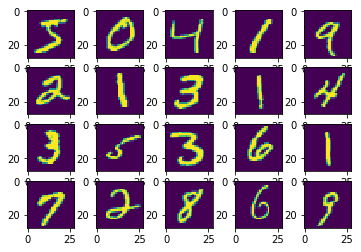

In [7]:
# show some images
plt.figure()
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

## Create models

In [29]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 labels
## Fully connected NN
class FC2Layer(nn.Module):
    def __init__(self, input_size,n_hidden, output_size):
        super(FC2Layer,self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,output_size),
            nn.LogSoftmax()
        )
    def forward(self, x):
        x = x.view(-1,self.input_size)
        return self.network(x)

    
## Convolutional NN   
class Convnet(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(Convnet,self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(1, n_feature,kernel_size= 5)
        self.conv2 = nn.Conv2d(n_feature,n_feature,kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10) # as 10 classes
        
    def forward(self, x, verbose =False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x)
        return x  

## Lets define train and test modules:

In [30]:
accuracy_list = list()

def train(epoch, model, perm = torch.arange(0,784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)    
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx%100==0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test(model, perm = torch.arange(0,784).long()):
    model.eval()
    test_loss=0
    correct=0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))     

In [31]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Lets Train Fully Connected NN: 

In [32]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.262342


/Users/aniruddhkhera/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.439713
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.939328
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.611498
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.615421
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.376399
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.452387
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.520108
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.232319
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.466811

Test set: Average loss: 0.3840, Accuracy: 8896/10000 (89%)



## Now lets train a ConvNet

In [33]:
# Training settings 
n_features    = 6     # number of feature maps

model = Convnet(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314385


/Users/aniruddhkhera/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.460055
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.621174
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.342388
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.362620
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.315854
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.174083
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.165584
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.105674
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.058061

Test set: Average loss: 0.2010, Accuracy: 9382/10000 (94%)



## The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images
* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

### What happens if the assumptions are no longer true?

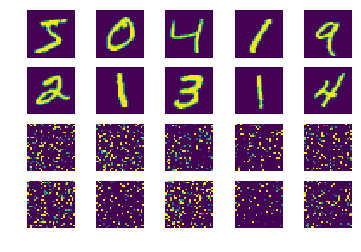

In [35]:
perm = torch.randperm(784)
plt.figure()
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [36]:
# Training settings 
n_features    = 6     # number of feature maps

model = Convnet(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model,perm)
    test(model,perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309754


/Users/aniruddhkhera/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.273612
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.205857
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.992892
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.533526
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.057614
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.848543
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.756832
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.630865
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.582609

Test set: Average loss: 0.5653, Accuracy: 8204/10000 (82%)



In [37]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model, perm)
    test(model, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307459


/Users/aniruddhkhera/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.896578
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.549642
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.328235
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.042029
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.710152
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.739613
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.563761
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.697724
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.516866

Test set: Average loss: 0.5252, Accuracy: 8274/10000 (83%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

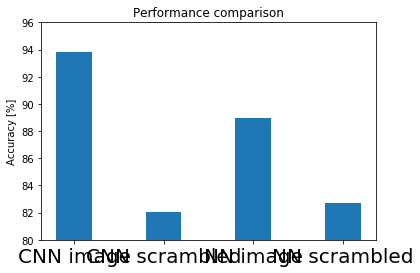

In [41]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=1)
plt.ylim((80, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');